# Modeling Demand for Analysis

**Target variable**: `Proj_TRN_RoomsPickup`: How many transient rooms will be booked for each stay date, from this point (8/1/17) forward, at current prices?

In [1]:
import pandas as pd
import numpy as np
import re
import datetime as dt
from agg import prep_demand_features
from demand_features import rf_cols, rf2_cols

pd.options.display.max_rows = 162
pd.options.display.max_columns = 250
pd.options.display.max_colwidth = None

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

DATE_FMT = "%Y-%m-%d"
as_of_date = "2017-06-01"

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
date_cols = ['StayDate',
 'STLY_StayDate',
 'AsOfDate',
 'STLY_AsOfDate',
 'AsOfDate_STLY',
 'StayDate_STLY']

h2_stats = pd.read_csv("../data/h2_stats.csv", parse_dates=date_cols, infer_datetime_format=True)
h2_stats.drop(columns=["STLY_Stay_Date", "STLY_AsOfDate", "Unnamed: 0"], errors='ignore', inplace=True) # remove dup. columns
h2_stats.reset_index(inplace=True)

C:\Users\Quotus\AppData\Local\Temp\ipykernel_13764\3821160413.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  h2_stats = pd.read_csv("../data/h2_stats.csv", parse_dates=date_cols, infer_datetime_format=True)


In [3]:
len(rf2_cols)

54

## Splitting Up Our Data for Train/Test

For a Revenue Management application:
* Our training set will contain all dates prior to as_of_date.
* Our testing set will contain 31 stay dates starting on as_of_date. Our predictions will be used to provide price recommendations later on.

In [4]:
# method for application

mask = (h2_stats["StayDate"] < as_of_date)
test_mask = (h2_stats['AsOfDate'] >= as_of_date)
df_train = h2_stats.loc[mask].copy()
df_test = h2_stats.loc[test_mask].copy()

X_train = df_train[rf2_cols].copy()
X_test = df_test[rf2_cols].copy()
y_train = df_train['ACTUAL_TRN_RoomsPickup'].copy()
y_test = df_test['ACTUAL_TRN_RoomsPickup'].copy()

## Final Model

Using the params generate in demand_model_selection

In [5]:
rf = RandomForestRegressor(n_estimators=550, n_jobs=-1, random_state=20)

rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7605373578664675

In [6]:
preds = rf.predict(X_test)

mean_absolute_error(y_test, preds)

3.314849860175125

In [7]:
h2_stat_preds = df_test.copy()
h2_stat_preds['DemandPrediction'] = preds
h2_stat_preds.head()

,index,id,DOW,RoomsOTB,RevOTB,CxlForecast,TRN_RoomsOTB,TRN_RevOTB,TRN_CxlForecast,TRNP_RoomsOTB,TRNP_RevOTB,TRNP_CxlForecast,GRP_RoomsOTB,CNT_RoomsOTB,StayDate,STLY_StayDate,DaysUntilArrival,Realized_Cxls,SellingPrice,TM30_RoomsOTB,TM30_RevOTB,TM30_TRN_RoomsOTB,TM30_TRN_RevOTB,TM30_TRNP_RoomsOTB,TM30_TRNP_RevOTB,TM15_RoomsOTB,TM15_RevOTB,TM15_TRN_RoomsOTB,TM15_TRN_RevOTB,TM15_TRNP_RoomsOTB,TM15_TRNP_RevOTB,TM05_RoomsOTB,TM05_RevOTB,TM05_TRN_RoomsOTB,TM05_TRN_RevOTB,TM05_TRNP_RoomsOTB,TM05_TRNP_RevOTB,AsOfDate,RemSupply,ADR_OTB,TRN_ADR_OTB,TRNP_ADR_OTB,LYA_RoomsSold,LYA_ADR,LYA_RoomRev,LYA_NumCancels,LYA_TRN_RoomsSold,LYA_TRN_ADR,LYA_TRN_RoomRev,LYA_TRNP_RoomsSold,LYA_TRNP_ADR,LYA_TRNP_RoomRev,ACTUAL_RoomsSold,ACTUAL_ADR,ACTUAL_RoomRev,ACTUAL_TRN_RoomsSold,ACTUAL_TRN_ADR,ACTUAL_TRN_RoomRev,ACTUAL_TRNP_RoomsSold,ACTUAL_TRNP_ADR,ACTUAL_TRNP_RoomRev,ACTUAL_NumCancels,ACTUAL_RoomsPickup,ACTUAL_ADR_Pickup,ACTUAL_RevPickup,ACTUAL_TRN_RoomsPickup,ACTUAL_TRN_ADR_Pickup,ACTUAL_TRN_RevPickup,ACTUAL_TRNP_RoomsPickup,ACTUAL_TRNP_ADR_Pickup,ACTUAL_TRNP_RevPickup,MonthNum,DayOfWeek,Mon,Sat,Sun,Thu,Tue,Wed,WE,week_of_year,TM30_ADR_OTB,TM30_RoomsPickup,TM30_RevPickup,TM30_ADR_Pickup,TM30_TRN_ADR_OTB,TM30_TRN_RoomsPickup,TM30_TRN_RevPickup,TM30_TRN_ADR_Pickup,TM30_TRNP_ADR_OTB,TM30_TRNP_RoomsPickup,TM30_TRNP_RevPickup,TM30_TRNP_ADR_Pickup,TM15_ADR_OTB,TM15_RoomsPickup,TM15_RevPickup,TM15_ADR_Pickup,TM15_TRN_ADR_OTB,TM15_TRN_RoomsPickup,TM15_TRN_RevPickup,TM15_TRN_ADR_Pickup,TM15_TRNP_ADR_OTB,TM15_TRNP_RoomsPickup,TM15_TRNP_RevPickup,TM15_TRNP_ADR_Pickup,TM05_ADR_OTB,TM05_RoomsPickup,TM05_RevPickup,TM05_ADR_Pickup,TM05_TRN_ADR_OTB,TM05_TRN_RoomsPickup,TM05_TRN_RevPickup,TM05_TRN_ADR_Pickup,TM05_TRNP_ADR_OTB,TM05_TRNP_RoomsPickup,TM05_TRNP_RevPickup,TM05_TRNP_ADR_Pickup,OTB_GapToLYA_RoomsSold,OTB_GapToLYA_ADR,OTB_GapToLYA_RoomRev,OTB_GapToLYA_NumCancels,OTB_GapToLYA_TRN_RoomsSold,OTB_GapToLYA_TRN_ADR,OTB_GapToLYA_TRN_RoomRev,OTB_GapToLYA_TRNP_RoomsSold,OTB_GapToLYA_TRNP_ADR,OTB_GapToLYA_TRNP_RoomRev,id_STLY,AsOfDate_STLY,StayDate_STLY,RoomsOTB_STLY,ADR_OTB_STLY,RevOTB_STLY,ACTUAL_RoomsPickup_STLY,ACTUAL_ADR_Pickup_STLY,ACTUAL_RevPickup_STLY,CxlForecast_STLY,RemSupply_STLY,SellingPrice_STLY,Realized_Cxls_STLY,TRN_RoomsOTB_STLY,TRN_ADR_OTB_STLY,TRN_RevOTB_STLY,TRN_CxlForecast_STLY,ACTUAL_TRN_RoomsPickup_STLY,ACTUAL_TRN_ADR_Pickup_STLY,ACTUAL_TRN_RevPickup_STLY,TRNP_RoomsOTB_STLY,TRNP_ADR_OTB_STLY,TRNP_RevOTB_STLY,TRNP_CxlForecast_STLY,ACTUAL_TRNP_RoomsPickup_STLY,ACTUAL_TRNP_ADR_Pickup_STLY,ACTUAL_TRNP_RevPickup_STLY,TM30_RoomsPickup_STLY,TM30_ADR_Pickup_STLY,TM30_RevPickup_STLY,TM30_TRN_RoomsPickup_STLY,TM30_TRN_ADR_Pickup_STLY,TM30_TRN_RevPickup_STLY,TM30_TRNP_RoomsPickup_STLY,TM30_TRNP_ADR_Pickup_STLY,TM30_TRNP_RevPickup_STLY,TM15_RoomsPickup_STLY,TM15_ADR_Pickup_STLY,TM15_RevPickup_STLY,TM15_TRN_RoomsPickup_STLY,TM15_TRN_ADR_Pickup_STLY,TM15_TRN_RevPickup_STLY,TM15_TRNP_RoomsPickup_STLY,TM15_TRNP_ADR_Pickup_STLY,TM15_TRNP_RevPickup_STLY,TM05_RoomsPickup_STLY,TM05_ADR_Pickup_STLY,TM05_RevPickup_STLY,TM05_TRN_RoomsPickup_STLY,TM05_TRN_ADR_Pickup_STLY,TM05_TRN_RevPickup_STLY,TM05_TRNP_RoomsPickup_STLY,TM05_TRNP_ADR_Pickup_STLY,TM05_TRNP_RevPickup_STLY,Pace_RoomsOTB,Pace_ADR_OTB,Pace_RevOTB,Pace_CxlForecast,Pace_RemSupply,Pace_SellingPrice,Pace_TRN_RoomsOTB,Pace_TRN_ADR_OTB,Pace_TRN_RevOTB,Pace_TRN_CxlForecast,Pace_TRNP_RoomsOTB,Pace_TRNP_ADR_OTB,Pace_TRNP_RevOTB,Pace_TRNP_CxlForecast,Pace_TM30_RoomsPickup,Pace_TM30_ADR_Pickup,Pace_TM30_RevPickup,Pace_TM30_TRN_RoomsPickup,Pace_TM30_TRN_ADR_Pickup,Pace_TM30_TRN_RevPickup,Pace_TM30_TRNP_RoomsPickup,Pace_TM30_TRNP_ADR_Pickup,Pace_TM30_TRNP_RevPickup,Pace_TM15_RoomsPickup,Pace_TM15_ADR_Pickup,Pace_TM15_RevPickup,Pace_TM15_TRN_RoomsPickup,Pace_TM15_TRN_ADR_Pickup,Pace_TM15_TRN_RevPickup,Pace_TM15_TRNP_RoomsPickup,Pace_TM15_TRNP_ADR_Pickup,Pace_TM15_TRNP_RevPickup,Pace_TM05_RoomsPickup,Pace_TM05_ADR_Pickup,Pace_TM05_RevPickup,Pace_TM05_TRN_RoomsPickup,Pace_TM05_TRN_ADR_Pickup,Pace_TM05_TRN_RevPickup,Pace

In [8]:
display_cols = [
    "DOW",
    "RemSupply",
    "RemSupply_STLY",
    "OTB_GapToLYA_TRN_RoomsSold",
    "ACTUAL_TRN_RoomsPickup",
    "DemandPrediction"
]
h2_stat_preds[display_cols].head()

,DOW,RemSupply,RemSupply_STLY,OTB_GapToLYA_TRN_RoomsSold,ACTUAL_TRN_RoomsPickup,DemandPrediction
9760,Thu,38.0,42.0,3.0,0.0,-1.007273
9761,Fri,23.0,58.0,-50.0,-3.0,-1.972727
9762,Sat,41.0,68.0,-49.0,4.0,1.923636
9763,Sun,45.0,100.0,-74.0,-1.0,1.601818
9764,Mon,20.0,25.0,-141.0,0.0,-1.960000


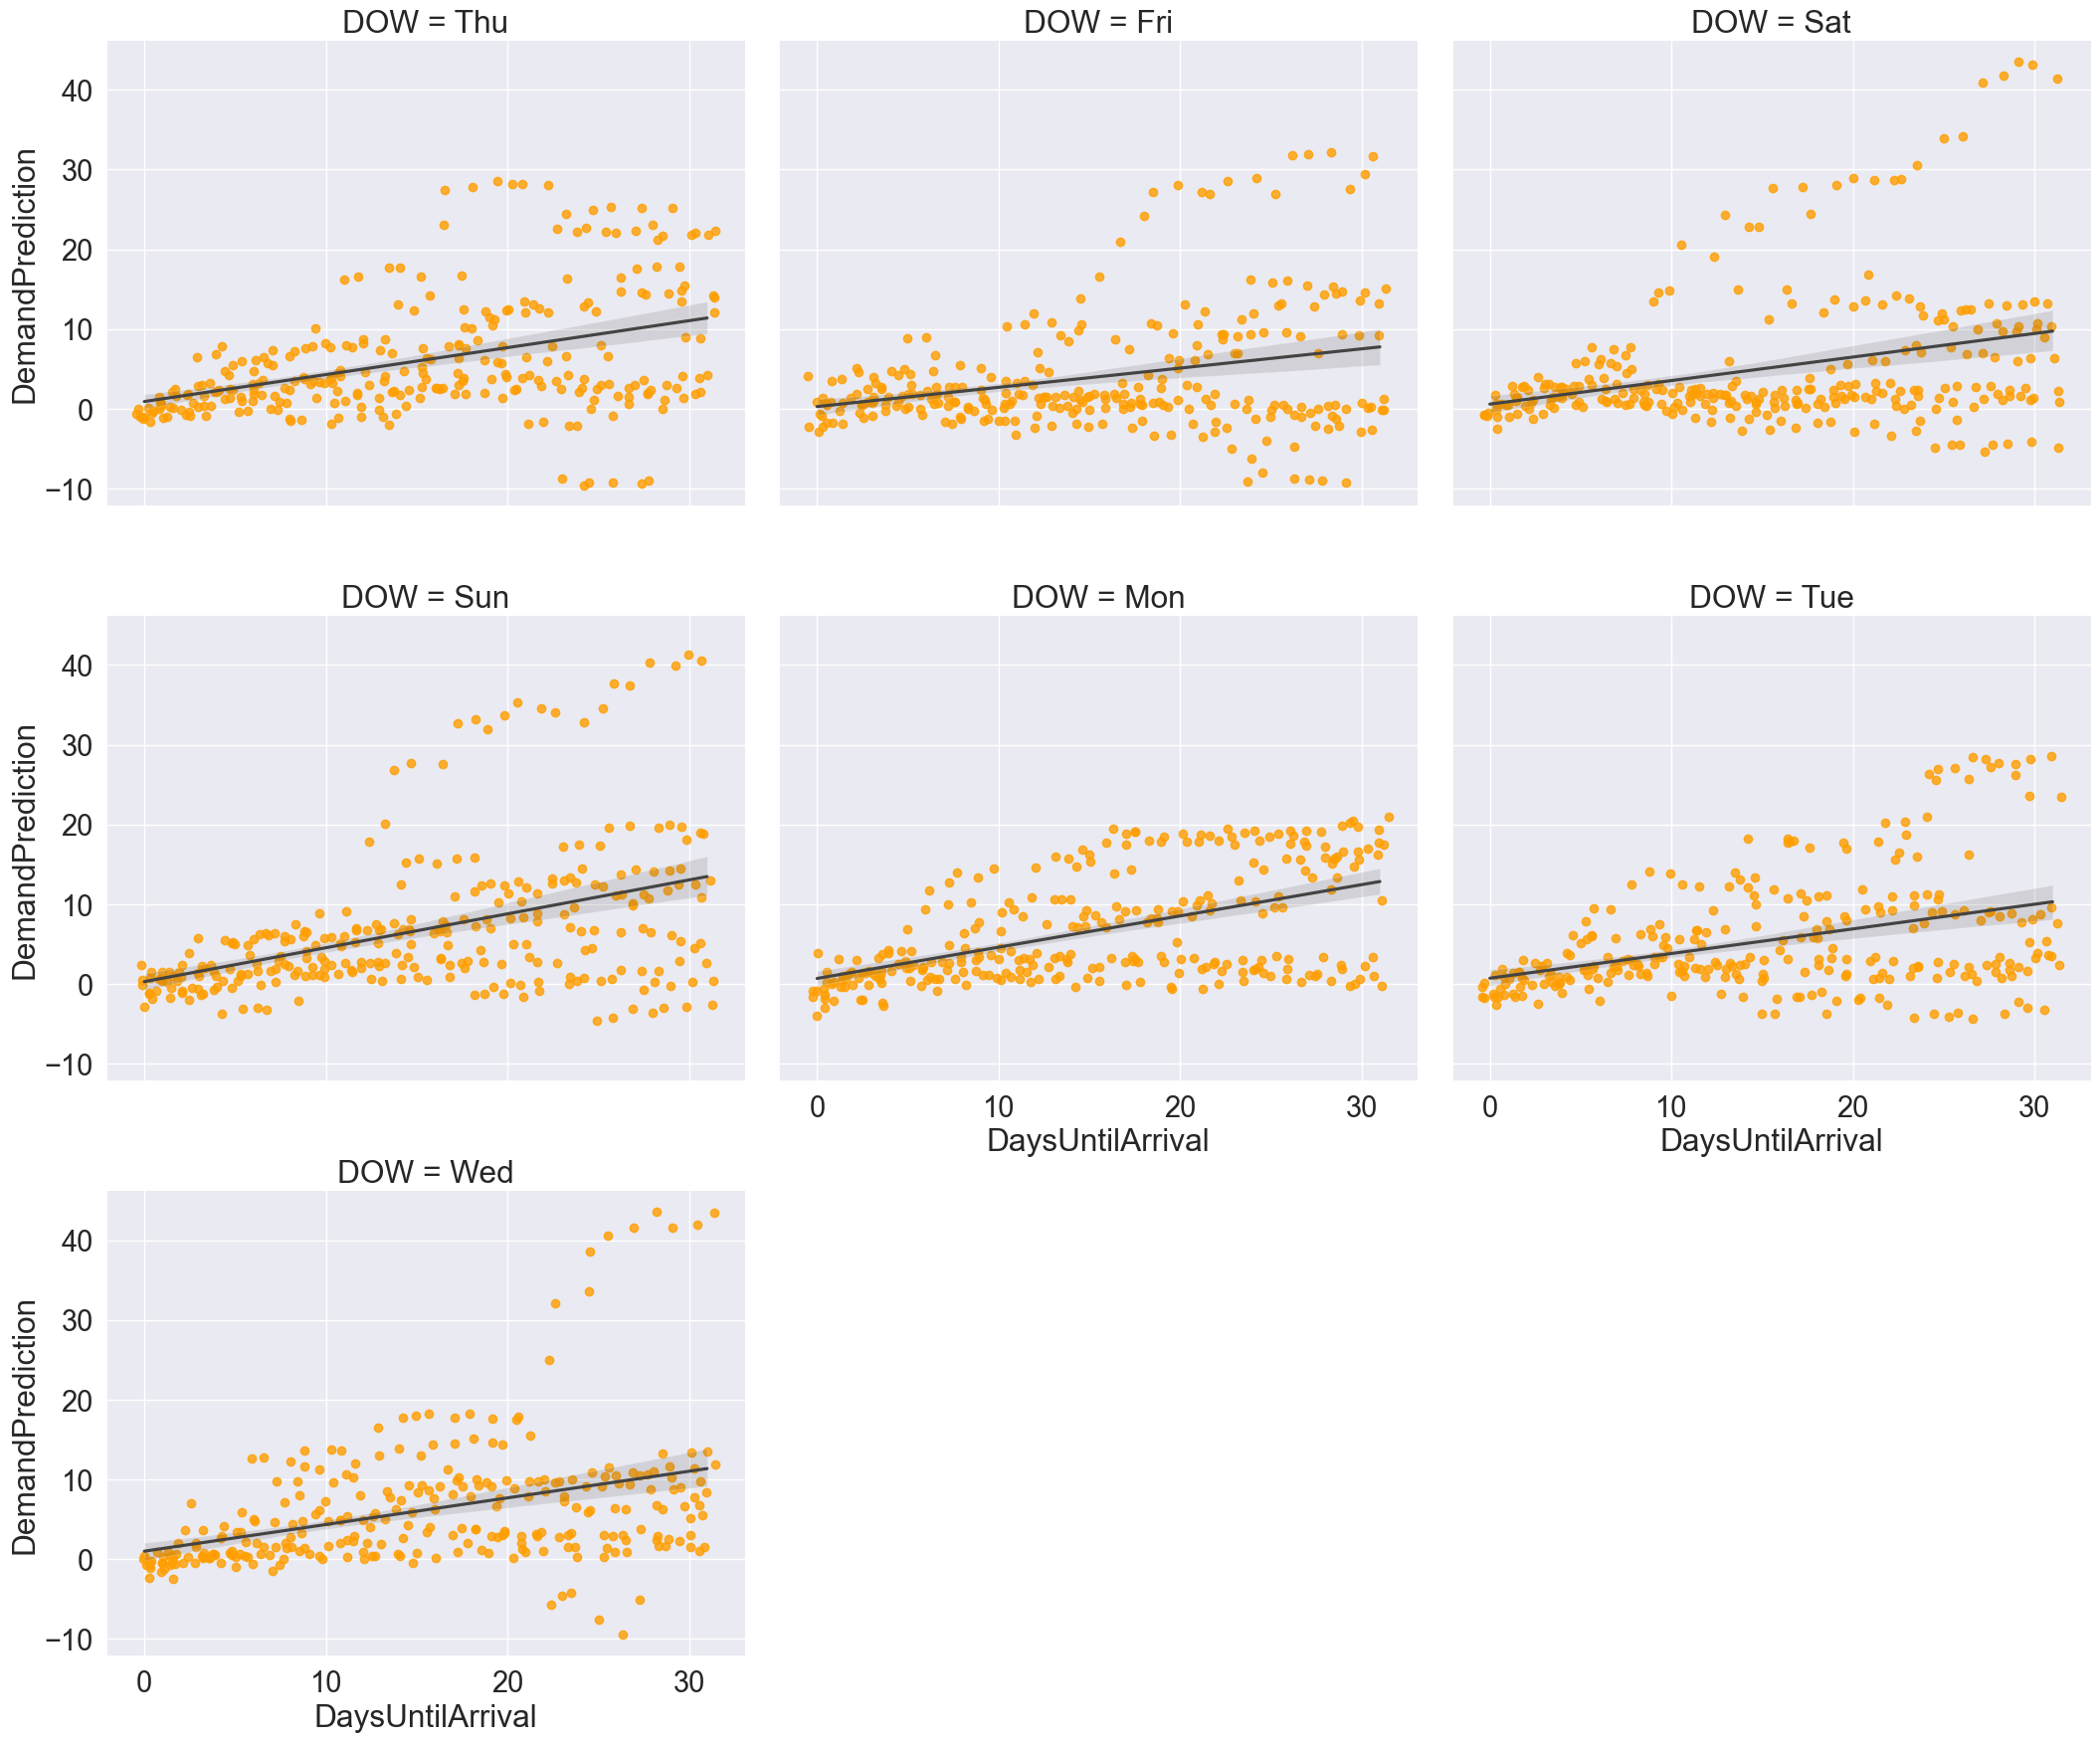

In [9]:
# plt.subplots(figsize=(14, 14))
title = "Outliers seem to pull line downwards further from arrival."
sns.set(font_scale=1.9)
ax = sns.lmplot(x="DaysUntilArrival", y="DemandPrediction", col='DOW', col_wrap=3, x_jitter=0.5, y_jitter=0.5, data=h2_stat_preds, height=6, aspect=1.2,
               scatter_kws={"color": "#ff9e00"}, line_kws={"color": "#434343"})

# title_font = {
#     "size": 18
# }

# label_font = {
#     "size": 16
# }
# plt.title(title, fontdict=title_font)
# plt.xlabel("Num Days Until Arrival", fontdict=label_font)
# plt.ylabel("Remaining Demand Prediction", fontdict=label_font)
plt.tight_layout()
plt.savefig("../etc/h2_lmplot_dow.jpeg", dpi=200)
plt.show()




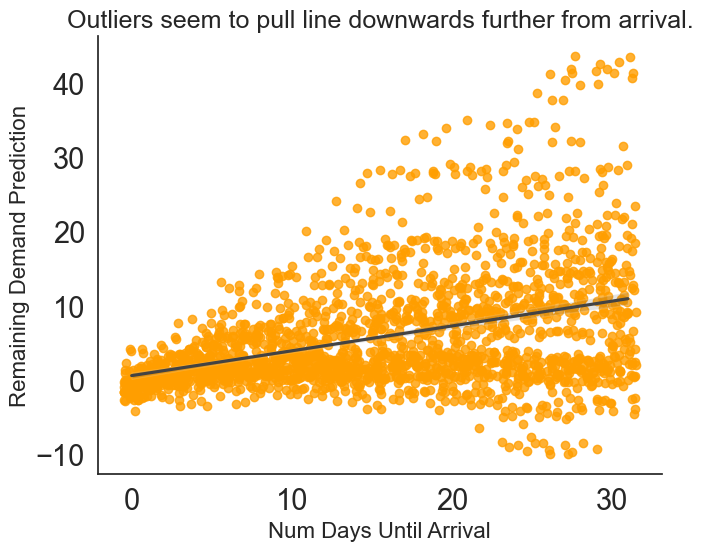

In [10]:
# plt.subplots(figsize=(14, 14))
sns.set_style("white")
title = "Outliers seem to pull line downwards further from arrival."

ax = sns.lmplot(x="DaysUntilArrival", y="DemandPrediction", x_jitter=0.5, y_jitter=0.5, data=h2_stat_preds, height=6, aspect=1.2,
               scatter_kws={"color": "#ff9e00"}, line_kws={"color": "#434343"})

title_font = {
    "size": 18
}

label_font = {
    "size": 16
}

plt.title(title, fontdict=title_font)
plt.xlabel("Num Days Until Arrival", fontdict=label_font)
plt.ylabel("Remaining Demand Prediction", fontdict=label_font)
plt.tight_layout()
plt.savefig("../etc/h2_lmplot.jpeg", facecolor='none', dpi=200)
plt.show()

## Now that we have our model, let's get it in the simulation so we can evaluate our results.

Head over to `demand_model_evaluation.ipynb` for more.